# Practical Application III: Comparing Classifiers - Marketing Campaign Analysis

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



## Imports & Utilities

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

# Export dataFrame's as images
import dataframe_image as dfi

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [5]:
# Configure logging
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%I:%M:%S %p')
# logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

# Switching logging config requires kernel restart - uncomment the test below to quickly verify settings
# logging.info("Logging output test")

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [6]:
# CONSTANTS FOR THE PROJECT
class Config:
    RANDOM_STATE = 42
    SUPPRESS_OUTPUT_FILES=False
    PAGE_WIDTH = 10
    TARGET_COLORS = ('indianred', 'seagreen')
    # TARGET_COLORS = ('red', 'green')


In [7]:
def time_secs_to_msg(lapse_time_secs, mins_label='m', secs_label='s'):
    if lapse_time_secs <= 60:
        return f'{lapse_time_secs%60:.2f}{secs_label}'
    else:
        return f'{lapse_time_secs//60:,.0f}{mins_label} {lapse_time_secs%60:.2f}{secs_label}'

In [8]:
# import warnings

# def graph_features(df, nrows, ncols, figsize=(7,7)):
#     """
#     Graph all the DataFrame columns as subplots to quickly visualize the features 
#     :param df: DataFrame to iterate on
#     :param nrows: Number of rows in subplot
#     :param ncols: Number of cols in subplot
#     :param fisize: list containing (widht, height)
#     """
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
    
#         fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        
#         # Flatten the axes array (makes it easier to iterate over)
#         axes = axes.flatten()
        
#         # Loop through each column and plot a histogram
#         for i, column in enumerate(df.columns):
            
#             # Add the histogram
#             df[column].hist(ax=axes[i], # Define on which ax we're working on
#                             edgecolor='white', # Color of the border
#                             color='#69b3a2' # Color of the bins
#                            )
            
#             # Add title and axis label
#             axes[i].set_title(f'{column}') 
#             axes[i].set_xlabel(column) 
#             axes[i].set_ylabel('Frequency')
#             # axes[i].set_xticklabels(df[column].values, rotation=45)
        
#         # Adjust layout
#         plt.tight_layout()
#         # plt.xticks(rotation=45)
        
#         # Show the plot
#         plt.show()

## Exploratory Data Analysis (EDA)

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [12]:
orig_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [13]:
orig_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [15]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Inspect: Nulls

In [17]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
orig_df.isnull().sum().transform(lambda x: (1 - (x / orig_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


age               100.0
job               100.0
marital           100.0
education         100.0
default           100.0
housing           100.0
loan              100.0
contact           100.0
month             100.0
day_of_week       100.0
duration          100.0
campaign          100.0
pdays             100.0
previous          100.0
poutcome          100.0
emp.var.rate      100.0
cons.price.idx    100.0
cons.conf.idx     100.0
euribor3m         100.0
nr.employed       100.0
y                 100.0
dtype: float64

No nulls - looking good!

### Inspect: Overall Features

Let's take a quick look at the feature distributions to see if anything jumps out:

In [21]:
categorical_cols = orig_df.select_dtypes(include=['object']).columns
numerical_cols = orig_df.select_dtypes(exclude=['object']).columns.tolist()

04:23:34 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04:23:34 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04:23:34 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04:23:35 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


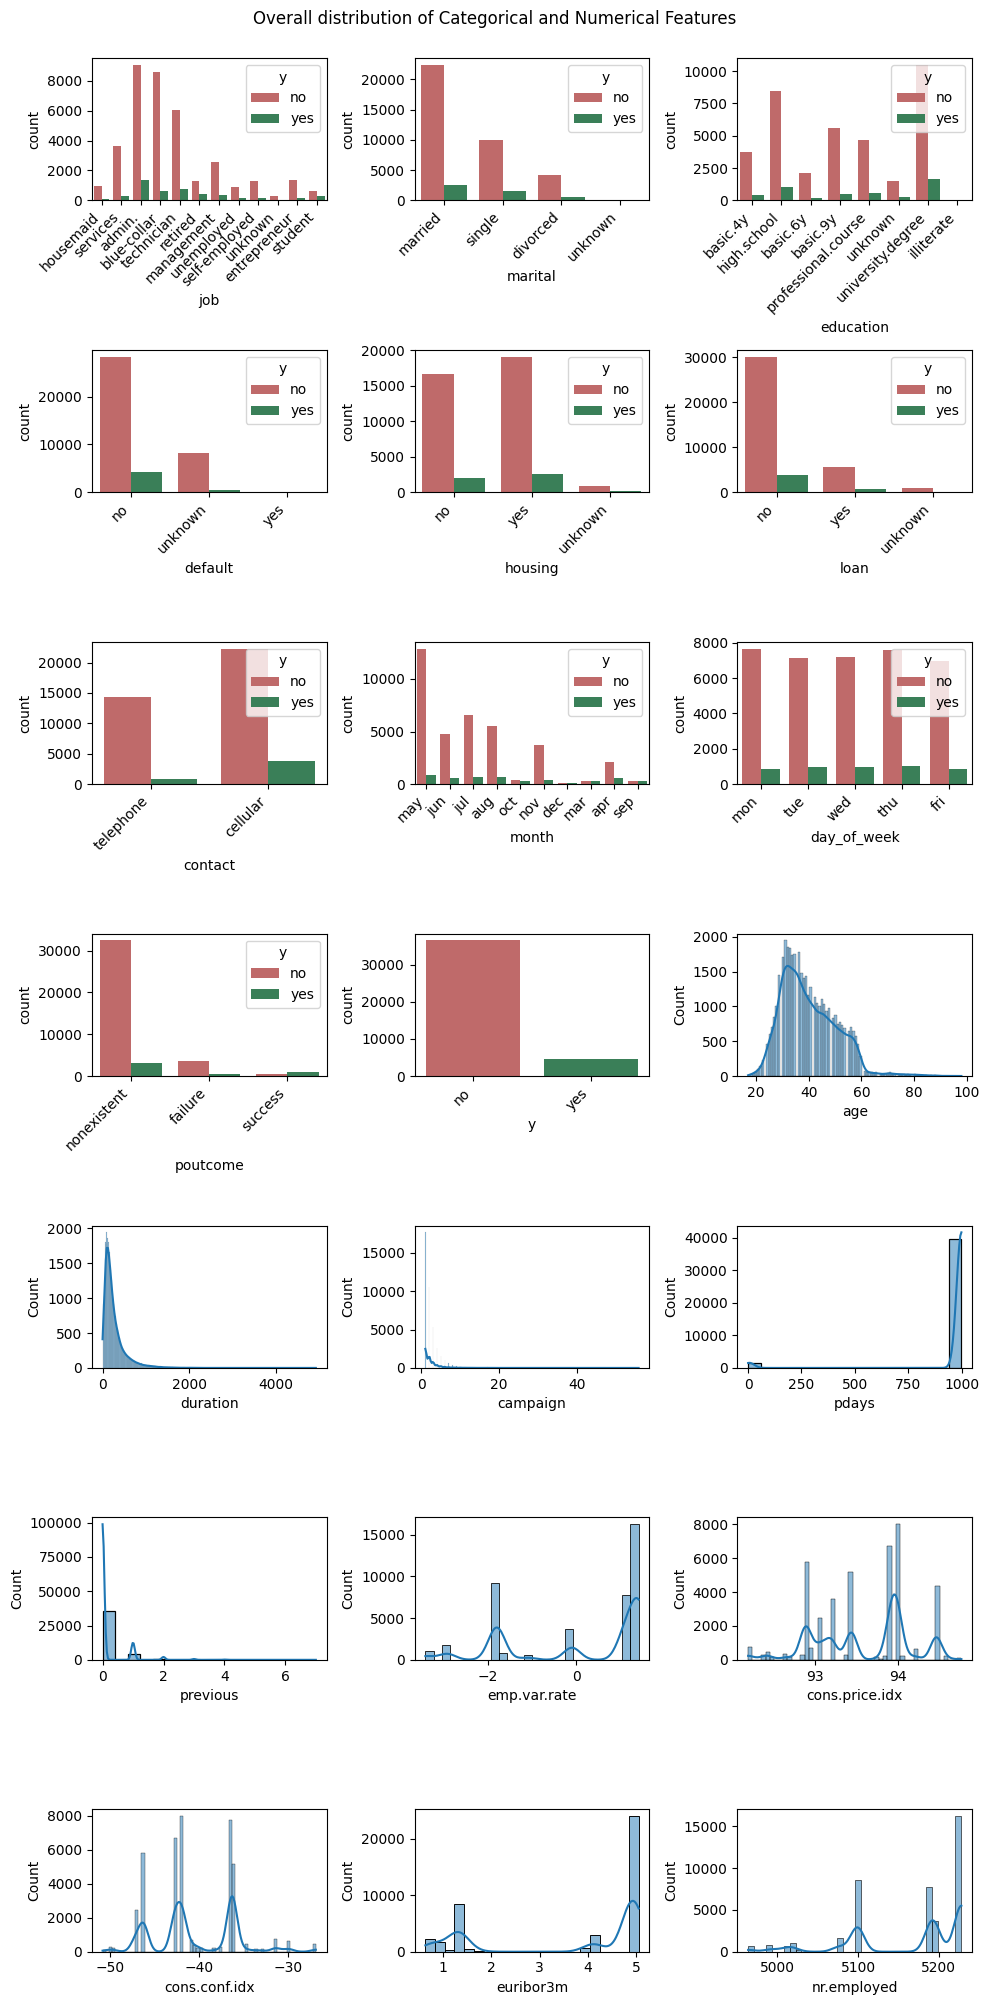

In [22]:
fig, axes = plt.subplots(7,3, figsize=(Config.PAGE_WIDTH, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate countplots for each categorical feature
for i, col in enumerate(categorical_cols):
    sns.countplot(ax=axes[i], x=col, data=orig_df, hue='y', palette=Config.TARGET_COLORS)
    # axes[i].set_title(f'Countplot of {col}')
    # Rotate x-axis labels by 45 degrees
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

# Generate histograms for numerical features
for j, col in enumerate(numerical_cols, start=len(categorical_cols)):
    sns.histplot(orig_df[col], ax=axes[j], kde=True)
    # axes[j].set_title(f'Histogram of {col}')

# Hide any unused subplots
for k in range(len(categorical_cols) + len(numerical_cols), len(axes)):
    fig.delaxes(axes[k])

plt.suptitle('Overall distribution of Categorical and Numerical Features', y=1.0)

# Adjust layout to prevent overlap
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/feature_distributions.png')

plt.show()

We don't have any nulls and the overall distributions look reasonable - we can't exclude anything at this stage as it may be relevant for modeling.

Some data concerns that we can note for now and may have to come back to them:

* `unknown` values for `marital`, `default`, `housing` and `loan` columns: I'm ignoring them for now, but if these features are important during modeling, then we may have to understand the significance of these values. This is specially concerning for `default` cases where the `unknown` value is significant
* `pdays` distribution shows that majority of the resepondents were not previously contacted (999), so this may be a red flag for removing this column

### Inspect: Target = Campaign Acceptance 

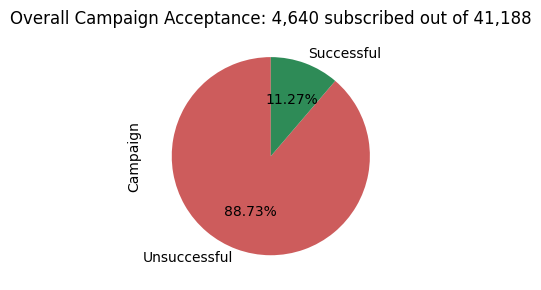

In [25]:
# Prep data for Pie chart
acceptance_rate_pie = orig_df.groupby('y')['y'].value_counts().rename('Campaign').reset_index()

# Calculate overall acceptance rate
nayes = acceptance_rate_pie.iloc[0, 1]
ayes = acceptance_rate_pie.iloc[1, 1]
acceptance_rate = (ayes / orig_df.shape[0]) * 100

names = ('Unsuccessful','Successful')
plt.rcParams['figure.figsize'] = (6,3)

acceptance_rate_pie.plot.pie(y='Campaign',
                             autopct='%1.2f%%', labels=names, legend=False,
                             colors=Config.TARGET_COLORS, startangle=90)
plt.title(f'Overall Campaign Acceptance: {ayes:,d} subscribed out of {orig_df.shape[0]:,d}')

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/pie-acceptance-overall.png')

plt.tight_layout()
plt.show()

### Inspect: Feature corelations

**To understand the feature correlations, I generated the Seaborn ``pairplot`` - it takes time to generate so the saved image is used instead**
```
sns.pairplot(orig_df, hue='y')

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/pairplot_raw_features.png')
    
plt.show()
```
![](images/pairplot_raw_features.png)

### Problem 4: Understanding the Task

**Business Objective**

This data is a collection of results from 17 Direct Marketing (DM) phone campaign conducted by a Portugese Bank (Customer) between May 2008 and November 2010, corressponding to 79,354 contacts, who were offered attractive, long-term deposit applications. As you can see below, for each contact, various demographic and bank relationship attributes are provided. A separate column `y` has been provided showing whether the offer was accepted or not, i.e. was the capaign successful or not. Our business objective is to help the Customer optimize their DM campagns in the future by predicting the likelihood of the campaign offer being accepted based on this data. 

In [29]:
orig_df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Data Modeling

### Problem 5: Engineering Features

Now that we understand our business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

Let's dig a little deeper - first we'll make a copy of the original data and transform it to aid our analysis:

In [33]:
encoded_df = orig_df.copy()

In [34]:
# Convert categorical variable to numeric data for the models to digest it
for col in categorical_cols:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

Let's quickly check to see how our target variable looks against the other feature attributes for any red flags:

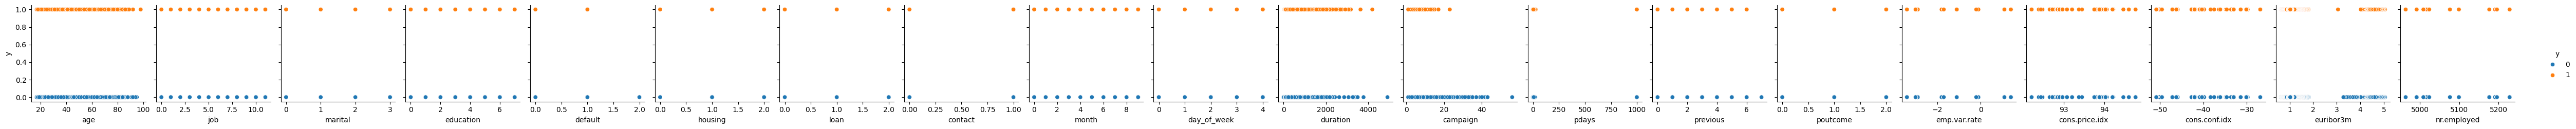

In [36]:
sns.pairplot(encoded_df, hue='y', y_vars='y')
plt.show()

Let's look at the correlation among the variables:

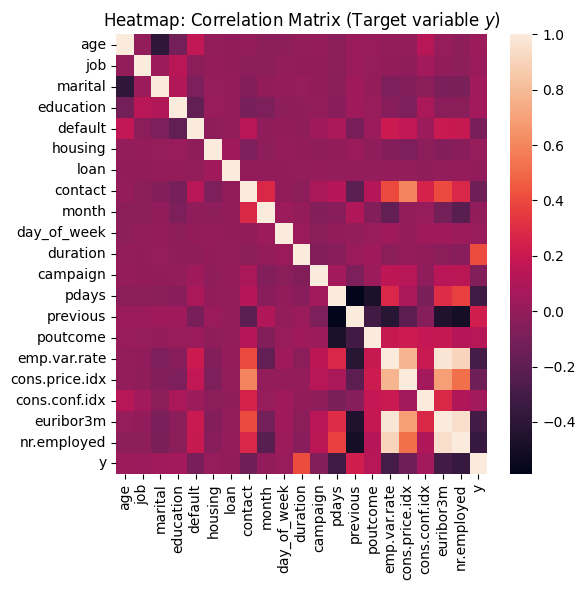

In [38]:
plt.figure(figsize=(6,6))
sns.heatmap(encoded_df.corr(), annot=False)

plt.title(f'Heatmap: Correlation Matrix (Target variable $y$)', y=1.0)
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/heatmap_cmatrix.png')
    
plt.show()

Most of the data seems to have reasonable correlations to the targe `y` variable, except for the bottom right of the matrix - too early to eliminate any data till we get preliminary results from our models.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [41]:
# Create the feature matrices for independnet and target variables

X = encoded_df.drop('y', axis='columns')
y = encoded_df['y']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=Config.RANDOM_STATE)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat? We will use the Scikit ML Library provided `DummyClassifier` with `strategy='uniform'` that will make _untratined_ predictions with equal probability among the two possible classes: Successful and Unsuccessful, without taking any of the call features into account. 

In [44]:
logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [45]:
# Scale the data - we'll use StandardScaler for the baseline model
logging.debug('Scaling data')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

04:24:43 PM DEBUG: Scaling data


In [46]:
logging.debug('Starting Baseline Model: DummyClassifier')
start_time = time.time()

# Train the model and get metrics
clf_dummy = DummyClassifier(strategy='uniform').fit(X_train_scaled, y_train)
y_preds = clf_dummy.predict(X_test_scaled)

# Save fit time
fit_time = time.time() - start_time

logging.debug(f'Done: DummyClassifier: {time_secs_to_msg(time.time()-start_time)}')

print(f'DummyClassifier Prediction Accuracy: {clf_dummy.score(y_test, y_preds) * 100 :,.2f}%')

04:24:43 PM DEBUG: Starting Baseline Model: DummyClassifier
04:24:43 PM DEBUG: Done: DummyClassifier: 0.01s


DummyClassifier Prediction Accuracy: 50.33%


In [47]:
print(classification_report(y_test, y_preds, target_names=['Unsuccessful', 'Successful']))

              precision    recall  f1-score   support

Unsuccessful       0.89      0.49      0.63      7310
  Successful       0.11      0.51      0.18       928

    accuracy                           0.49      8238
   macro avg       0.50      0.50      0.41      8238
weighted avg       0.80      0.49      0.58      8238



As expected, the predictions from the DummyClassifier are about as good as a coin toss, but that is the baseline score for our business use case!

### Problem 8: A Simple Model

Let's try a linear regression model to see if we can do better!

In [50]:
logging.debug('Starting Simple Model: LogisticRegression')
start_time = time.time()

# Train the model and get metrics
clf_logistic = LogisticRegression().fit(X_train_scaled, y_train)
y_preds = clf_logistic.predict(X_test_scaled)

# Save fit time
fit_time = time.time() - start_time

logging.debug(f'Done: LogisticRegression: {time_secs_to_msg(time.time()-start_time)}')

04:24:44 PM DEBUG: Starting Simple Model: LogisticRegression
04:24:44 PM DEBUG: Done: LogisticRegression: 0.41s


### Problem 9: Score the Model

What is the accuracy of your model?

In [52]:
print(f'LogisticRegression Prediction Accuracy: {accuracy_score(y_test, y_preds) * 100 :,.2f}%')

LogisticRegression Prediction Accuracy: 91.42%


In [53]:
print(classification_report(y_test, y_preds, target_names=['Unsuccessful', 'Successful']))

              precision    recall  f1-score   support

Unsuccessful       0.93      0.98      0.95      7310
  Successful       0.70      0.41      0.52       928

    accuracy                           0.91      8238
   macro avg       0.82      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238



As we can see, the default `LogisticRegression` did much better out of the gate than the _dumb_ model, 50% vs over 90%! Let's see if we can do better now with more sophisticated models.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [56]:
# Define the default models
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC(probability=True)
}

results = {}
results_preds = {}
results_probs = {}
results_cm = {}
for name, model in models.items():
    print(f'{name}: Starting', flush=True)
    start_time = time.time()

    # train the model
    clf = model.fit(X_train_scaled, y_train)
    logging.debug(f'{name}: Fitted')

    # Save fit time
    fit_time = time.time() - start_time

    # get the predictions / probabilities
    y_preds = clf.predict(X_test_scaled)
    y_probs = clf.predict_proba(X_test_scaled)[:, 1]
    logging.debug(f'{name}: Got metrics')

    # Save metrics
    results[name] = {
        # 'Model': name,
        'Train Time': time_secs_to_msg(fit_time),
        'Train Accuracy': model.score(X_train_scaled, y_train),
        'Test Accuracy': model.score(X_test_scaled, y_test),
        'Precision': precision_score(y_test, y_preds),
        'Recall': recall_score(y_test, y_preds),
        'F1': f1_score(y_test, y_preds),
        'AUC': roc_auc_score(y_test, y_probs),
    }
    results_preds[name] = y_preds
    results_probs[name] = y_probs
    results_cm[name] = confusion_matrix(y_test, y_preds)
    
    print(f'{name}: Done - {time_secs_to_msg(time.time()-start_time)}', flush=True)

KNeighborsClassifier: Starting


04:24:45 PM DEBUG: KNeighborsClassifier: Fitted
04:24:55 PM DEBUG: KNeighborsClassifier: Got metrics


KNeighborsClassifier: Done - 21.94s
DecisionTreeClassifier: Starting


04:25:07 PM DEBUG: DecisionTreeClassifier: Fitted
04:25:07 PM DEBUG: DecisionTreeClassifier: Got metrics


DecisionTreeClassifier: Done - 0.36s
SVC: Starting


04:27:40 PM DEBUG: SVC: Fitted
04:27:55 PM DEBUG: SVC: Got metrics


SVC: Done - 3m 29.18s


In [57]:
pd.DataFrame(results).T

,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1,AUC
KNeighborsClassifier,0.04s,0.92695,0.905924,0.631218,0.396552,0.487095,0.861058
DecisionTreeClassifier,0.22s,1.0,0.881646,0.478301,0.55819,0.515167,0.740449
SVC,2m 32.64s,0.919211,0.914542,0.716216,0.399784,0.51314,0.918697


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions